# CSC413/2516 Project


# Hyperparameter Sensitivity Analysis for Adam Optimization on Deep CNNs

Abhishek Madan and Fei Wu

# Code Overview
The code from this notebook is adapted from the notebook used for PA2, though with several modifications. Aside from the different networks implemented for this project, the training loop and model evaluation code now return a per-image classification distribution instead of a per-pixel classification distribution.

Since we ran all of our experiments in the free tier of Colab, the experiments were run one at a time, changing hyperparameters and re-running for each experiment, with the relevant results pickled and downloaded after each run. The pickle files were loaded and plotted offline, though no training or other analysis was done offline. As such, the plotting code is not included in the submission.

#### Helper code
You can ignore the restart warning.

In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/csc413/a2/
%cd /content/csc413/a2

######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

/content/csc413/a2


#### Download files

This may take 1 or 2 mins for the first time.

In [ ]:
# Download cluster centers for k-means over colours
colours_fpath = get_file(
    fname="colours", origin="http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz", untar=True
)
# Download CIFAR dataset
m = load_cifar10()

File path: data/colours.tar.gz
Extracting file.
File path: data/cifar-10-batches-py.tar.gz
Extracting file.


## Helper code

In [ ]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# from load_data import load_cifar10

HORSE_CATEGORY = 7

#### Data related code

In [ ]:
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i : i + batch_size, :, :, :], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result


def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours, 1, 3, 1, 1])
    dists = np.linalg.norm(xs - cs, axis=2)  # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat


def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]


def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by shuffling, subtracting the per-pixel mean,
    and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      ys: shuffled category labels
    """
    indices = npr.permutation(xs.shape[0])

    xs = xs / max_pixel
    pixel_avg = np.mean(xs, axis=0, keepdims=True)
    xs = xs - pixel_avg

    return xs[indices, :, :, :], ys[indices].reshape(-1)


def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output labels
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size]
        yield (batch_x, batch_y)

#### Torch helper

In [ ]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


def compute_loss(criterion, outputs, labels, batch_size, num_classes):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_classes (int): number of image categories
    Returns:
      pytorch tensor for loss
    """
    return criterion(outputs, labels)


def run_validation_step(
    cnn,
    criterion,
    x_test_proc,
    y_test_proc,
    batch_size,
    num_classes,
    plotpath=None,
    visualize=True,
    downsize_input=False
):
    correct = 0.0
    total = 0.0
    losses = []
    for i, (xs, ys) in enumerate(get_batch(x_test_proc, y_test_proc, batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(
            criterion, outputs, labels, batch_size=args.batch_size, num_classes=num_classes
        )
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

#### Visualization

In [ ]:
def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10, :, :, :], [0, 2, 3, 1])
    gtcolor = get_cat_rgb(gtlabel[:10, 0, :, :], colours)
    predcolor = get_cat_rgb(output[:10, 0, :, :], colours)

    img_stack = [np.hstack(np.tile(grey, [1, 1, 1, 3])), np.hstack(gtcolor), np.hstack(predcolor)]

    if compare_bilinear:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Upsample(scale_factor=2, mode="bilinear"),
        )
        gt_input = np.transpose(
            gtcolor,
            [
                0,
                3,
                1,
                2
            ],
        )
        color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
        color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
        img_stack = [
            np.hstack(np.transpose(input[:10, :, :, :], [0, 2, 3, 1])),
            np.hstack(gtcolor),
            np.hstack(predcolor),
            np.hstack(color_bilinear),
        ]
    img = np.vstack(img_stack)

    plt.grid(None)
    plt.imshow(img, vmin=0.0, vmax=1.0)
    if visualize:
        plt.show()
    else:
        plt.savefig(path)


def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax) * 255).astype(np.uint8))


def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]

    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + "/act" + str(id)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    images, labels = get_torch_vars(
        np.expand_dims(test_grey[id], 0), np.expand_dims(test_rgb_cat[id], 0)
    )
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0, 0, :, :], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1).save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
        img = np.tile(np.transpose(test_grey[id], [1, 2, 0]), [1, 1, 3])
    else:
        img = np.transpose(test_grey[id], [1, 2, 0])
    toimage(img, cmin=0, cmax=1).save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id], [1, 2, 0])
    toimage(img, cmin=0, cmax=1).save(os.path.join(outdir, "input_%d_gt.png" % id))

    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=4):
        img = np.vstack(
            [
                np.hstack(
                    [
                        add_border(filter)
                        for filter in activation[i * imgwidth : (i + 1) * imgwidth, :, :]
                    ]
                )
                for i in range(activation.shape[0] // imgwidth)
            ]
        )
        scipy.misc.imsave(path, img)

    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4, cnn.out5]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i + 1, id)), tensor.data.cpu().numpy()[0]
        )
    print("visualization results are saved to %s" % outdir)

#### Training

In [ ]:
from google.colab import files

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # INPUT CHANNEL
    num_in_channels = 3
    # Network size (parameterized by n)
    N = 6
    # Num classes (10 for CIFAR10)
    num_classes = 10
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, args.num_filters, num_classes, num_in_channels, N)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate, betas=(args.beta1, args.beta2), eps=args.epsilon)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    x_train_proc, y_train_proc = process(x_train, y_train, downsize_input=args.downsize_input)
    x_test_proc, y_test_proc = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(x_train_proc, y_train_proc, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(
                criterion, outputs, labels, batch_size=args.batch_size, num_classes=num_classes
            )
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(
            cnn,
            criterion,
            x_test_proc,
            y_test_proc,
            args.batch_size,
            num_classes,
            save_dir + "/test_%d.png" % epoch,
            args.visualize,
            args.downsize_input,
        )

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)
    
    config_data = {}
    config_data['train_losses'] = [l.item() for l in train_losses]
    config_data['valid_losses'] = [l.item() for l in valid_losses]
    config_data['valid_accs'] = [a.item() for a in valid_accs]
    config_outfile = save_dir + '/losses_{}_a{}_b{}_bb{}_e{}.pickle'.format(
        args.model, args.learn_rate, args.beta1, args.beta2, args.epsilon
    )
    with open(config_outfile, 'wb') as f:
      pickle.dump(config_data, f, pickle.HIGHEST_PROTOCOL)
    files.download(config_outfile)

    return cnn

# VGGNet

## Code


In [ ]:
class VGGNet(nn.Module):
    def __init__(self, kernel, num_filters, num_classes, num_in_channels, n):
        super().__init__()

        # Useful parameters
        padding = kernel // 2

        self.fconv = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )

        layers1 = []
        layers2 = []
        layers3 = []
        for i in range(n-1):
          layers1.append(nn.Sequential(
              nn.Conv2d(num_filters, num_filters, kernel, padding=padding),
              nn.BatchNorm2d(num_filters),
              nn.ReLU()
          ))
          layers2.append(nn.Sequential(
              nn.Conv2d(2*num_filters, 2*num_filters, kernel, padding=padding),
              nn.BatchNorm2d(2*num_filters),
              nn.ReLU()
          ))
          layers3.append(nn.Sequential(
              nn.Conv2d(4*num_filters, 4*num_filters, kernel, padding=padding),
              nn.BatchNorm2d(4*num_filters),
              nn.ReLU()
          ))

        layers1.append(nn.Sequential(
            nn.Conv2d(num_filters, 2*num_filters, kernel, padding=padding, stride=2),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
        ))
        layers2.append(nn.Sequential(
            nn.Conv2d(2*num_filters, 4*num_filters, kernel, padding=padding, stride=2),
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU()
        ))
        layers3.append(nn.Sequential(
            nn.Conv2d(4*num_filters, 4*num_filters, kernel, padding=padding),
            nn.BatchNorm2d(4*num_filters),
            nn.ReLU()
        ))

        self.conv1 = nn.Sequential(*layers1)
        self.conv2 = nn.Sequential(*layers2)
        self.conv3 = nn.Sequential(*layers3)

        self.avg = nn.AvgPool2d(8)
        self.output = nn.Linear(4*num_filters, num_classes)

    def forward(self, x):
        x = self.fconv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg(x).squeeze()
        return self.output(x)

## Train

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/15], Loss: 1.5085, Time (s): 41
Epoch [1/15], Val Loss: 1.3227, Val Acc: 51.2%, Time(s): 43.51
Epoch [2/15], Loss: 1.0596, Time (s): 84
Epoch [2/15], Val Loss: 1.0212, Val Acc: 64.2%, Time(s): 86.92
Epoch [3/15], Loss: 0.8627, Time (s): 127
Epoch [3/15], Val Loss: 0.9761, Val Acc: 65.9%, Time(s): 130.32
Epoch [4/15], Loss: 0.7430, Time (s): 171
Epoch [4/15], Val Loss: 0.8482, Val Acc: 70.7%, Time(s): 173.70
Epoch [5/15], Loss: 0.6584, Time (s): 214
Epoch [5/15], Val Loss: 0.7888, Val Acc: 73.3%, Time(s): 217.10
Epoch [6/15], Loss: 0.5916, Time (s): 258
Epoch [6/15], Val Loss: 0.7182, Val Acc: 76.1%, Time(s): 260.46
Epoch [7/15], Loss: 0.5367, Time (s): 301
Epoch [7/15], Val Loss: 0.7851, Val Acc: 74.4%, Time(s): 303.81
Epoch [8/15], Loss: 0.4847, Time (s): 344
Epoch [8/15], Val Loss: 0.8669, Val Acc: 72.6%, Time(s): 347.22
Epoch [9/15], Loss: 0.4428, Time (s): 388
Epoch [9/15

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

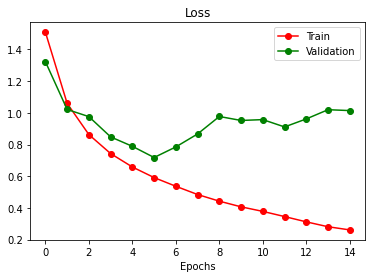

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "VGGNet",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001,
    'beta1':0.9,
    'beta2':0.99999,
    'epsilon':1e-8, 
    "batch_size": 100,
    "epochs": 15,
    "seed": 0,
    "plot": False,
    "experiment_name": "adam_sensitivity",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

# ResNet

## Code

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, shortcut=None, stride=1):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels)
    )

    self.relu = nn.ReLU()
    self.shortcut = shortcut

  def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)

        if self.shortcut is not None:
            identity = self.shortcut(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet34(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, kernel, num_filters, num_classes, num_in_channels, n):
        super().__init__()
        self.layer0 = nn.Sequential(
          nn.Conv2d(num_in_channels, num_filters, kernel_size=7, stride=2, padding=3,bias=False),
          nn.BatchNorm2d(num_filters),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=kernel, stride=2, padding=1)
          
        )

        self.layer1 = self.make_layer(num_filters,num_filters*2, 4, stride=1) 
        self.layer2 = self.make_layer(num_filters*2,num_filters*4, 4,stride=2)
        self.layer3 = self.make_layer(num_filters*4,num_filters*4,6,stride=2) 
        self.layer4 = self.make_layer(num_filters*4,num_filters*8,3,stride=2)
        
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1))

        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_filters*8, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []

        shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
        )
        layers.append(ResidualBlock(in_channels, out_channels, shortcut, stride))
        for i in range(num_blocks - 1):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)     

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

## Train

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/15], Loss: 1.7978, Time (s): 32
Epoch [1/15], Val Loss: 1.5223, Val Acc: 44.5%, Time(s): 34.43
Epoch [2/15], Loss: 1.3975, Time (s): 66
Epoch [2/15], Val Loss: 1.3784, Val Acc: 50.3%, Time(s): 68.76
Epoch [3/15], Loss: 1.1332, Time (s): 101
Epoch [3/15], Val Loss: 1.3610, Val Acc: 52.0%, Time(s): 102.88
Epoch [4/15], Loss: 0.8766, Time (s): 135
Epoch [4/15], Val Loss: 1.4234, Val Acc: 51.6%, Time(s): 137.13
Epoch [5/15], Loss: 0.6335, Time (s): 169
Epoch [5/15], Val Loss: 1.5497, Val Acc: 52.2%, Time(s): 171.30
Epoch [6/15], Loss: 0.4500, Time (s): 203
Epoch [6/15], Val Loss: 1.7069, Val Acc: 52.8%, Time(s): 205.49
Epoch [7/15], Loss: 0.3647, Time (s): 237
Epoch [7/15], Val Loss: 1.8760, Val Acc: 52.3%, Time(s): 239.71
Epoch [8/15], Loss: 0.3042, Time (s): 272
Epoch [8/15], Val Loss: 1.9224, Val Acc: 52.2%, Time(s): 273.92
Epoch [9/15], Loss: 0.2666, Time (s): 306
Epoch [9/15

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

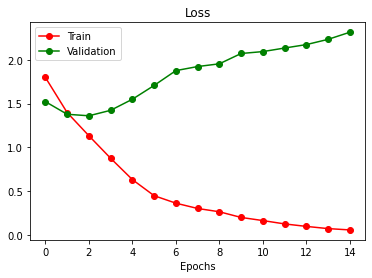

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "ResNet34",
    "kernel": 3,
    "num_filters": 64,
    'learn_rate':0.001,
    'beta1':0.9,
    'beta2':0.999,
    'epsilon':1e-8, 
    "batch_size": 100,
    "epochs": 15,
    "seed": 0,
    "plot": False,
    "experiment_name": "adam_sensitivity",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

In [ ]:
!nvidia-smi

Tue Apr 19 16:31:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------